<a href="https://colab.research.google.com/github/Saxena224pawan/llm_projects/blob/main/NLP_train_Headline_enc-dec%20seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

In [2]:
# prompt: check device cuda or cpu

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
Device name: Tesla T4


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = pd.read_csv('news_summary.csv')

In [6]:
dataset.tail()

,headlines,text
29660,I would've loved to play under Kohli in IPL: V...,Cricket legend Viv Richards has said that he w...
29661,There will never be another AB de Villiers: Da...,Veteran South African fast bowler Dale Steyn t...
29662,Sad we won't bat together again: SA captain as...,"In his farewell message for AB de Villiers, wh..."
29663,Real Madrid player replicates bin challenge wi...,Brazilian left back Marcelo took the header bi...
29664,Amazon lets users track package delivery in re...,Amazon has launched a feature called Amazon Ma...


### Why ASCII format is important?
- **Standardization**: ASCII format standardizes text data to a set of 128 characters, including commonly used letters, digits, and symbols in English.
- **Simplified Encoding/Decoding**: Ensures ease of encoding and decoding processes by utilizing a uniform character set.
- **Compatibility**: Helps avoid complications with non-English and special characters found in other encodings like UTF-8.
- **Error Reduction**: Using ASCII can reduce errors in text processing tasks, particularly when dealing with large datasets or systems with limited character support.
- **Integration Simplicity**: Facilitates easier integration between systems that may not support broader character sets, minimizing complexities.

In [7]:
# Preprocessing function
def preprocess_text(df, col):
    # converting language data in data frame to lower case and then storing in sentence variable
    sentence = df[col].str.lower()
    sentence = sentence.str.replace('[^0-9A-Za-z\s]+', '', regex=True)
    sentence = sentence.str.normalize('NFD')
    #encoding the string in sentence in UTF-8 format and ignoring errors if any
    sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8')
    return sentence

In [8]:
dataset['headlines'] = preprocess_text(dataset, 'headlines')
dataset['text'] = preprocess_text(dataset, 'text')

In [9]:
dataset.tail()

,headlines,text
29660,i wouldve loved to play under kohli in ipl viv...,cricket legend viv richards has said that he w...
29661,there will never be another ab de villiers dal...,veteran south african fast bowler dale steyn t...
29662,sad we wont bat together again sa captain as a...,in his farewell message for ab de villiers who...
29663,real madrid player replicates bin challenge wi...,brazilian left back marcelo took the header bi...
29664,amazon lets users track package delivery in re...,amazon has launched a feature called amazon ma...


In [10]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

# make the token 1 and 2 ,0 is already reserved for the [pad]
class Vocab:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:'PAD',1: "SOS", 2: "EOS"}
        self.n_words = 3  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


### **Explanation-**
The provided Python script introduces a `Vocab` class specifically tailored for language processing tasks that involve handling vocabulary in various natural language processing (NLP) applications. The class is structured to maintain a mapping of words to their respective indices and to keep a count of the frequency of each word's occurrence.

Key elements of the `Vocab` class include:
1. **Initialization**: The constructor (`__init__`) sets up three dictionaries:
   - `word2index`: Maps words to their unique integer indices.
   - `word2count`: Stores the frequency count of each word.
   - `index2word`: Maps indices back to their corresponding words.
   Additionally, it initializes three special tokens:
   - `PAD` (index 0): Used for padding shorter sentences to a common length.
   - `SOS` (index 1): "Start of Sentence" token, often used in models to signal the beginning of a new sentence.
   - `EOS` (index 2): "End of Sentence" token, used to indicate the termination of a sentence.

2. **Adding Words and Sentences**:
   - `add_sentence(sentence)`: This method takes a string input, splits it into individual words, and processes each word through the `add_word` method.
   - `add_word(word)`: This method checks if a word is already in the `word2index` dictionary. If it is not, the word is added to this dictionary with an incrementing index, added to the `index2word` dictionary with the corresponding index, and initialized in the `word2count` dictionary with a count of one. If the word is already known, only its count in `word2count` is incremented.

3. **Utility and Tracking**:
   - The `n_words` attribute keeps track of the total number of unique words, starting from 3 to account for the three special tokens.

This class facilitates the construction of a vocabulary from scratch, allowing for dynamic updates as new words are encountered. It is particularly useful in settings where the vocabulary needs to be expanded based on the input data, such as in machine learning models for language translation, text summarization, or other NLP tasks that require tokenization of text data.

In [11]:
#create vocab instance
vocab = Vocab()

_ = dataset.text.apply(lambda x: vocab.add_sentence(x))
_ = dataset.headlines.apply(lambda x: vocab.add_sentence(x))

In [12]:
vocab.n_words

64582

In [13]:
#calculate and store the length of each text and headline
dataset['text_length'] = dataset.text.str.split(' ').apply(lambda x: len(x))
dataset['headlines_length'] = dataset.headlines.str.split(' ').apply(lambda x: len(x))

In [14]:
dataset.headlines_length.max(), dataset.text_length.max()

(18, 67)

In [15]:
MAX_LENGTH_INPUT = 100
MAX_LENGTH_TARGET = 20

In [16]:
# function to convert a sentence into a list of indices based on the vocabulary
def indexes_from_sentence(vocab, sentence):
    return [vocab.word2index[word] for word in sentence.split(' ')]

In [17]:
# convert a sentence into a list of indices, and then appends the EOS_token
def tensor_from_sentence(vocab, sentence):
    indexes = indexes_from_sentence(vocab, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


In [18]:
# prepare dataloader
def get_dataloader(dataset, batch_size):
    n = dataset.shape[0]
    input_ids = np.zeros((n, MAX_LENGTH_INPUT), dtype=np.int64)
    target_ids = np.zeros((n, MAX_LENGTH_TARGET), dtype=np.int64)

    for idx in range(n):
        inp_ids = indexes_from_sentence(vocab, dataset.text.iloc[idx])
        tgt_ids = indexes_from_sentence(vocab, dataset.headlines.iloc[idx])

        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)

        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    return train_dataloader

### Explanation-

1. Function Definition and Initial Setup
- **Function Initialization**: `get_dataloader(dataset, batch_size)` is designed to accept a dataset containing textual data and headlines, along with a batch size that dictates how many sequences each batch will contain.
- **Storage Arrays Creation**: Initializes two numpy arrays, `input_ids` and `target_ids`, with zeros. The arrays are sized based on the total number of entries (`n`) in the dataset and the predefined maximum lengths (`MAX_LENGTH_INPUT` for input texts and `MAX_LENGTH_TARGET` for target headlines). These arrays will hold the indexed representations of each sentence.

2. Converting Sentences to Indexed Sequences
- **Processing Each Dataset Entry**: Iterates over each entry in the dataset. For each text and headline:
  - **Indexing**: Converts the text to a list of indices using `indexes_from_sentence(vocab, dataset.text.iloc[idx])` and does the same for the headline.
  - **Appending EOS Tokens**: Adds an EOS token to the end of each indexed list, indicating the end of the sequences. This is critical for models to understand where sequences end during prediction.

3. Populating the Storage Arrays
- **Filling Arrays**: Each list of indexed words (including the EOS token) for the input texts and target headlines is used to populate corresponding rows in the `input_ids` and `target_ids` arrays. The sequences are left-padded with zeros to ensure that all sequences within a batch have the same length, which is necessary for processing in neural networks.

4. Setting Up TensorDataset and DataLoader
- **TensorDataset Creation**: Transforms the populated `input_ids` and `target_ids` into PyTorch tensors and combines them into a `TensorDataset`. This dataset facilitates the pairing of each input sequence with its corresponding target sequence, crucial for supervised learning.
- **RandomSampler and DataLoader**: Incorporates a `RandomSampler` to shuffle the dataset entries thoroughly. This shuffling prevents the model from learning any biases or patterns from the sequence order in the dataset. The `DataLoader` is then set up with this `TensorDataset` and `RandomSampler`, and configured to yield data in batches of the specified `batch_size`.

5. Return of DataLoader
- **Output**: Returns the fully configured `train_dataloader`, which is now ready to be used in the training loop of a sequence-to-sequence model. This DataLoader provides batches of indexed, padded, and shuffled sequences, ensuring efficient data handling and contributing to effective model training through improved data variability and computational optimization.

This chronologically ordered description delineates each step involved in the data preparation process facilitated by the `get_dataloader` function, making it clear how it contributes to setting up data for efficient training in NLP models.









One important aspect to note is that in this implementation, we are not utilizing pre-trained embeddings such as Word2Vec, which were discussed in Module 3 for handling sequential data. Instead, we are training the embeddings from scratch. This approach is particularly beneficial for large datasets where sufficient data is available to develop robust, domain-specific embeddings without the need for pre-trained models. Even though we do not have a very large dataset in this problem, we are using this strategy for experimentation.

In [19]:
#define encoder class
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        # Make LSTM bidirectional
        self.lstm = nn.LSTM(hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        # When LSTM is bidirectional, the output, hidden and cell state will be for both directions
        output, (hidden, cell) = self.lstm(embedded)
        return output, (hidden, cell)

In [20]:
#initialize encoder
enc = Encoder(100, 64)
print(enc)

Encoder(
  (embedding): Embedding(100, 64)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [21]:
#creating simulated input
x = torch.randint(1, 100, (1, 61))

In [22]:
#pass tensor x through encoder model
enc_outputs, enc_hidden = enc.forward(x)

In [23]:
enc_hidden_h_shape = enc_hidden[0].shape
enc_hidden_c_shape = enc_hidden[1].shape
enc_outputs_shape = enc_outputs.shape

print("enc_outputs_shape:", enc_outputs_shape)
print("enc_hidden_h_shape:", enc_hidden_h_shape)
print("enc_hidden_c_shape:", enc_hidden_c_shape)

enc_outputs_shape: torch.Size([1, 61, 128])
enc_hidden_h_shape: torch.Size([2, 1, 64])
enc_hidden_c_shape: torch.Size([2, 1, 64])



The shapes of the outputs from the encoder indicate the following:

- enc_outputs_shape: torch.Size([1, 61, 128]) tells us that the encoder output a sequence of 61 time steps for a single batch, and each time step's output is a 128-dimensional vector. This output represents the LSTM's output at each step.
- enc_hidden_h_shape: torch.Size([1, 1, 64]) shows that the hidden state is a 64-dimensional vector for a single layer of the LSTM, applicable to one batch. This state captures the learned features from the input sequence up to the last time step.
- enc_hidden_c_shape: torch.Size([1, 1, 64]) similarly reveals that the cell state is also a 64-dimensional vector for one layer and one batch, indicating the LSTM's internal state that helps control the flow of information.

And next, we define the Decoder class. This class generates sequential outputs based on the context from an encoder. It starts with an embedding layer converting input indices into dense vectors. A unidirectional LSTM processes these vectors, using states adapted from the encoder's bidirectional output. The model employs teacher forcing during training, where actual previous outputs are fed as inputs, enhancing learning stability. Outputs are passed through a linear layer, and the sequence of predictions is formed by applying a softmax function, facilitating effective word prediction in generated sequences. This architecture is essential for tasks like machine translation, where accurate sequential generation based on context is crucial. We have given a detailed explanation below.

In [24]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size * 2  # Adjust hidden size if states are concatenated
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Assuming concatenation of hidden states, adjust LSTM input size
        self.lstm = nn.LSTM(hidden_size, self.hidden_size, batch_first=True)
        self.out = nn.Linear(self.hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)

        # Combine or adapt encoder_hidden to suit unidirectional decoder
        encoder_hidden = self.adapt_hidden(encoder_hidden)

        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH_TARGET):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)

        return decoder_outputs, decoder_hidden

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.out(output)
        return output, hidden

    def adapt_hidden(self, hidden):
        # Assuming hidden is a tuple (hidden_state, cell_state) each with dimensions [2, batch_size, hidden_size]
        hidden_state, cell_state = hidden
        # Concatenate the forward and backward states
        hidden_state = torch.cat((hidden_state[0:hidden_state.size(0):2], hidden_state[1:hidden_state.size(0):2]), dim=2)
        cell_state = torch.cat((cell_state[0:cell_state.size(0):2], cell_state[1:cell_state.size(0):2]), dim=2)
        return (hidden_state, cell_state)


**Explanation-**

1. **Initialization (`__init__` method)**:
   - **Hidden Size Adjustment**: The decoder initializes with an adjusted `hidden_size`, doubling it to accommodate the concatenated forward and backward states from a bidirectional LSTM encoder.
   - **Embedding Layer**: An embedding layer is created to transform input indices into dense vector representations, with the embedding dimension set to `hidden_size`.
   - **LSTM Layer**: A unidirectional LSTM is used for decoding. The input size is `hidden_size`, and the output size is the adjusted `hidden_size`.
   - **Output Layer**: A linear layer that maps from the LSTM output size to the `output_size`, which typically corresponds to the vocabulary size of the output language or target.

2. **Forward Pass (`forward` method)**:
   - **Initial Setup**: Starts by preparing a `decoder_input` initialized with the start-of-sequence (SOS) token, ensuring the decoder knows where to begin sequence generation.
   - **Adapt Hidden States**: The hidden states from the encoder (which may be bidirectional) are adapted for use in the unidirectional LSTM of the decoder through the `adapt_hidden` method.
   - **Sequence Generation Loop**:
     - The loop runs for each position up to `MAX_LENGTH_TARGET` to generate the required sequence length.
     - **Embedding and Activation**: At each step, the current input token is embedded and passed through a ReLU activation function.
     - **LSTM Computation**: The LSTM processes the activated embedding along with the current hidden state.
     - **Output Generation**: The LSTM's output is then passed to the linear layer to produce a vector of scores corresponding to the likelihood of each token in the vocabulary.
     - **Teacher Forcing Option**: If a `target_tensor` is provided (during training), it uses this tensor's next token as the input for the next step (teacher forcing). Otherwise, it uses the most likely token from the current output.
   - **Sequence Concatenation**: The outputs across all time steps are concatenated to form the final sequence.

3. **Forward Step (`forward_step` method)**:
   - This method is called by the main forward loop of the decoder and handles the processing of input tokens into output tokens for each timestep.

4. **Adapt Hidden States (`adapt_hidden` method)**:
   - **State Concatenation**: Assuming the encoder's hidden states are from a bidirectional LSTM, this method concatenates the forward and backward components of the hidden and cell states to create a new state suitable for the unidirectional LSTM in the decoder.

This structured approach enables the decoder to effectively generate sequences by capturing the dependencies of the input sequence, provided by the encoder's output and adapted states, and transforming them into a coherent output sequence step-by-step.

In [25]:
#generate random target tensors
tgt_tensor = torch.randint(1, 100, (1, 20))
tgt_tensor.shape

torch.Size([1, 20])

In [26]:
#initialise the decoder class
dec = Decoder(64, 100)

In [27]:
# Assuming you have a device variable defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move your models to the designated device
encoder = enc.to(device)
decoder = dec.to(device)


In [28]:
# When you load or create tensors, send them to the same device
enc_outputs = enc_outputs.to(device)
(h,c) = enc_hidden
enc_hidden_gpu=h.to(device),c.to(device)
tgt_tensor = tgt_tensor.to(device)


In [29]:
#execute forward pass of decoder instance
decoder_outputs, decoder_hidden= dec.forward(enc_outputs, enc_hidden_gpu, tgt_tensor)

In [30]:
decoder_hidden_h_shape = decoder_hidden[0].shape
decoder_hidden_c_shape = decoder_hidden[1].shape
decoder_outputs_shape = decoder_outputs.shape

print("decoder_outputs_shape:", decoder_outputs_shape)
print("decoder_hidden_h_shape:", decoder_hidden_h_shape)
print("decoder_hidden_c_shape:", decoder_hidden_c_shape)

decoder_outputs_shape: torch.Size([1, 20, 100])
decoder_hidden_h_shape: torch.Size([1, 1, 128])
decoder_hidden_c_shape: torch.Size([1, 1, 128])


In [31]:
train_dataset, test_dataset = train_test_split(dataset, shuffle=True, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, shuffle=True, test_size=0.1, random_state=42)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Train set size: 21358
Validation set size: 2374
Test set size: 5933


In [32]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for input_tensor, target_tensor in tqdm(dataloader):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate_model(dataloader, encoder, decoder, criterion):
    total_loss = 0
    with torch.no_grad():
        for input_tensor, target_tensor in tqdm(dataloader):
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            total_loss += loss.item()

    return total_loss / len(dataloader)

def train_model(train_dataloader, valid_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
                print_every=100, plot_every=100):
    print_loss_total = 0  # Reset every print_every
    train_losses = []
    valid_losses = []

    best_val_loss = float('inf')

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch: {epoch}/{n_epochs}")
        # Training
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer,
                                 decoder_optimizer, criterion)
        print_loss_total += train_loss
        train_losses.append(train_loss)

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"Train Loss: {round(print_loss_avg, 3)}")

        # Validation
        print('Validation....')
        valid_loss = evaluate_model(valid_dataloader, encoder, decoder, criterion)
        valid_losses.append(valid_loss)
        print(f"Validation Loss: {round(valid_loss, 3)}")

        # Save the model if it has the best validation loss so far
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(encoder.state_dict(), 'best_encoder.pth')
            torch.save(decoder.state_dict(), 'best_decoder.pth')
            print(f"Saved Best Model at Epoch: {epoch}")

    return train_losses, valid_losses


**Explanation:**

#### Training Epoch (`train_epoch` function):
- **Initialization**: Sets the total loss for the epoch to zero.
- **Batch Processing**:
  - Zeroes out gradients for both encoder and decoder optimizers to prevent accumulation from previous iterations.
  - Computes encoder and decoder outputs by passing the input tensors through the models.
  - Calculates the loss using a criterion that compares the decoder's output to the target tensor.
  - Performs backpropagation by calling `loss.backward()`.
  - Updates the encoder and decoder weights using their respective optimizers.
  - Accumulates the loss over all batches.
- **Epoch Conclusion**: Returns the average loss for the epoch.

#### Evaluation (`evaluate_model` function):
- **Initialization**: Prepares for evaluation by setting the total loss to zero.
- **Batch Evaluation**:
  - With gradient calculations disabled (`torch.no_grad()`), processes each batch by computing encoder and decoder outputs, and calculates loss similarly to the training phase but without updating weights.
  - Aggregates total loss across all batches.
- **Evaluation Conclusion**: Returns the average loss for the validation dataset.

#### Model Training (`train_model` function):
- **Setup**: Initializes optimizers for the encoder and decoder and sets the loss criterion.
- **Epoch Loop**:
  - For each epoch, calls `train_epoch` to train the model and `evaluate_model` to assess its performance on the validation set.
  - Logs and prints training loss periodically and updates the running total of the training loss.
  - After each epoch, evaluates the model, logs the validation loss, and saves the model state if it has the best validation loss observed so far.
- **Training Conclusion**: Completes the training after the specified number of epochs and returns lists of training and validation losses for further analysis.

This workflow provides a comprehensive mechanism for training and evaluating a seq2seq model, crucial for tasks like machine translation or time series prediction, where learning sequential dependencies is key.

Now let us create a workflow to for our sequence-to-sequence model.
It begins by setting key parameters: hidden_size at 256, batch_size at 64, and n_epochs equaling 10. The code then initializes data loaders for both training and validation datasets, ensuring that data is batched and ready for processing. Subsequently, the Encoder and Decoder are defined with specified sizes and moved to the appropriate computing device (GPU or CPU). The encoder and decoder are integral to the seq2seq model, handling input sequence processing and generating output sequences. The train_model function is called to train these models over the defined number of epochs, with specific intervals for printing the training loss and validating the model's performance on unseen data. This training loop is crucial for adjusting the model's weights based on error gradients and improving its prediction accuracy over time.

In [ ]:
hidden_size = 256
batch_size = 64
n_epochs =10

print('Making DataLoaders .... .....  ')
train_dataloader = get_dataloader(train_dataset, batch_size)
val_dataloader=get_dataloader(val_dataset,batch_size)
print('Defining Encoder and Decoder .....')
encoder = Encoder(vocab.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, vocab.n_words).to(device)

train_model(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=1, plot_every=100)

Making DataLoaders .... .....  
Defining Encoder and Decoder .....
Epoch: 1/10


100%|██████████| 334/334 [01:04<00:00,  5.19it/s]


Train Loss: 4.276
Validation....


100%|██████████| 38/38 [00:02<00:00, 16.24it/s]


Validation Loss: 3.897
Saved Best Model at Epoch: 1
Epoch: 2/10


100%|██████████| 334/334 [01:06<00:00,  5.06it/s]


Train Loss: 3.595
Validation....


100%|██████████| 38/38 [00:02<00:00, 17.54it/s]


Validation Loss: 3.587
Saved Best Model at Epoch: 2
Epoch: 3/10


100%|██████████| 334/334 [01:06<00:00,  5.02it/s]


Train Loss: 3.131
Validation....


100%|██████████| 38/38 [00:02<00:00, 17.30it/s]


Validation Loss: 3.401
Saved Best Model at Epoch: 3
Epoch: 4/10


100%|██████████| 334/334 [01:06<00:00,  5.01it/s]


Train Loss: 2.692
Validation....


100%|██████████| 38/38 [00:02<00:00, 17.45it/s]


Validation Loss: 3.314
Saved Best Model at Epoch: 4
Epoch: 5/10


100%|██████████| 334/334 [01:06<00:00,  5.02it/s]


Train Loss: 2.281
Validation....


100%|██████████| 38/38 [00:02<00:00, 17.41it/s]


Validation Loss: 3.238
Saved Best Model at Epoch: 5
Epoch: 6/10


100%|██████████| 334/334 [01:06<00:00,  5.02it/s]


Train Loss: 1.906
Validation....


100%|██████████| 38/38 [00:02<00:00, 17.45it/s]


Validation Loss: 3.251
Epoch: 7/10


 51%|█████     | 169/334 [00:33<00:33,  4.99it/s]

In [ ]:
def evaluate_test_samples(encoder, decoder, sentence, vocab):
    with torch.no_grad():
        input_tensor = tensor_from_sentence(vocab, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(vocab.index2word[idx.item()])

    return decoded_words


The NLTK METEOR score is a metric used to evaluate the quality of machine-generated text against a reference or human-generated text. It calculates a similarity score based on the harmonic mean of unigram precision and recall, with a penalty term for matching chunks. It accounts for variations in word order, synonyms, and paraphrases by aligning words between the generated and reference texts. This alignment is performed using a WordNet-based matching algorithm. The resulting score ranges from 0 to 1, where higher scores indicate better similarity between the generated and reference texts, thus reflecting the quality of the generated text.

And then we run this cell. Make sure the NLTK packages are downloaded.

In [ ]:
def evaluateRandomly_train(encoder, decoder, vocab, n=10):
    for i in range(n):
        print(i)
        eval_sample = train_dataset.iloc[i:i+1, :]
        print('news_article > ', eval_sample['text'].iloc[0])
        headline = eval_sample['headlines'].iloc[0]
        print('original_headline = ', headline)
        output_words = evaluate_test_samples(encoder, decoder, eval_sample.text.iloc[0], vocab)
        output_sentence = ' '.join(output_words)
        print('predicted_headline < ', output_sentence)
        print(f"meteor score: {nltk.translate.meteor_score.single_meteor_score(headline.split(), output_sentence.split())}")

In [ ]:
tips_data =pd.read_csv('/content/tips.csv')

In [ ]:
tips_data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [ ]:
tips_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [ ]:
#tips_data['total_bill_plus_tip' ] = tips_data['total_bill'] + tips_data['tip']

<Axes: xlabel='day', ylabel='total_bill'>

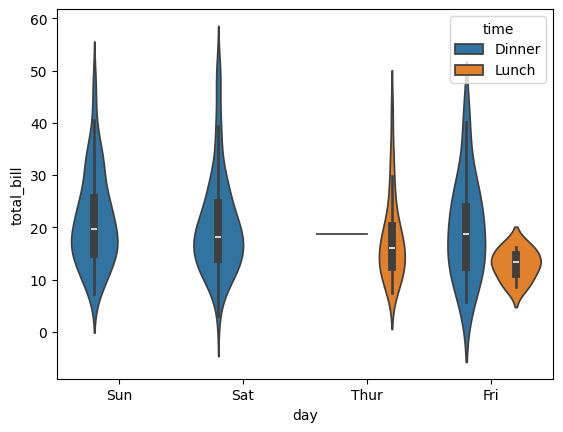

In [ ]:
sns.violinplot(x='day', y='total_bill', hue ='time', data=tips_data)

In [ ]:
tips_data.groupby(['day', 'time'])['total_bill'].count()

day   time  
Fri   Dinner    12
      Lunch      7
Sat   Dinner    87
Sun   Dinner    76
Thur  Dinner     1
      Lunch     61
Name: total_bill, dtype: int64

In [ ]:
tips_data.groupby(['day', 'time'])['total_bill'].mean()

day   time  
Fri   Dinner    19.663333
      Lunch     12.845714
Sat   Dinner    20.441379
Sun   Dinner    21.410000
Thur  Dinner    18.780000
      Lunch     17.664754
Name: total_bill, dtype: float64

In [ ]:
tips_data.groupby(['day'])['smoker'].value_counts(normalize=True)

day   smoker
Fri   Yes       0.789474
      No        0.210526
Sat   No        0.517241
      Yes       0.482759
Sun   No        0.750000
      Yes       0.250000
Thur  No        0.725806
      Yes       0.274194
Name: proportion, dtype: float64

In [ ]:
tips_data.groupby(['smoker']).agg({'total_bill': ['mean','count']})

total_bill      
             mean count
smoker                 
No      19.188278   151
Yes     20.756344    93

<Axes: >

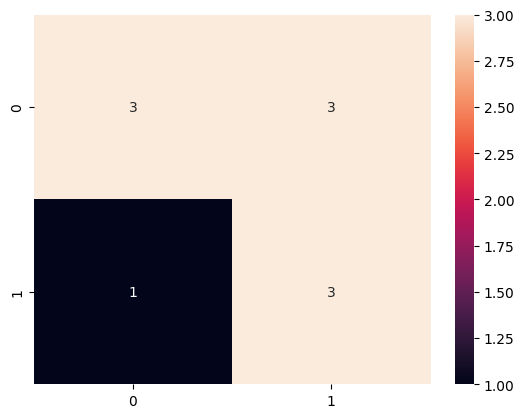

In [ ]:

from collections import Counter

str = "leetcode"

import numpy as np
from sklearn.metrics import confusion_matrix
actual = np.array([1,1,0,1,0,0,1,0,0,0])
predicted = np.array([1,0,1,1,1,0,1,1,0,0])
sns.heatmap(confusion_matrix(actual, predicted), annot=True)